En total hay 11434 caracteres, y el diccionario tiene un tamaño de 32 caracteres.
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, None, 32)]           0         []                            
                                                                                                  
 input_38 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 simple_rnn_20 (SimpleRNN)   [(None, 24),                 1368      ['input_37[0][0]',            
                              (None, 24)]                            'input_38[0][0]']            
                                                                                                  
 dense_26

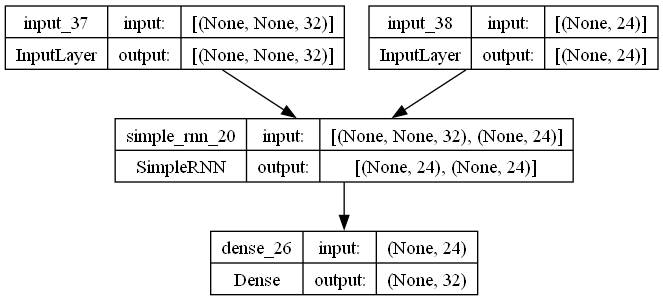

In [26]:
import numpy as np
np.random.seed(5)

from keras.layers import Input, Dense, SimpleRNN
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import backend as K

# 1. LECTURA DEL SET DE DATOS
# ===========================================================
nombres = open('/mnt/d/Repositorios/Deep_Learning/RN/P3/Nombres/nombres_mujeres.txt','r').read()
nombres = nombres.lower()

# Crear diccionario (listado de caracteres que no se repiten)
alfabeto = list(set(nombres))
tam_datos, tam_alfabeto = len(nombres), len(alfabeto)
print("En total hay %d caracteres, y el diccionario tiene un tamaño de %d caracteres." % (tam_datos, tam_alfabeto))

# Conversión de caracteres a índices y viceversa
car_a_ind = { car:ind for ind,car in enumerate(sorted(alfabeto))}
ind_a_car = { ind:car for ind,car in enumerate(sorted(alfabeto))}
#print(car_a_ind)
#print(ind_a_car)

# 2. MODELO
# ===========================================================
n_a = 24    # Número de unidades en la capa oculta
entrada  = Input(shape=(None,tam_alfabeto))
a0 = Input(shape=(n_a,))

celda_recurrente = SimpleRNN(n_a, activation='tanh', return_state = True)
capa_salida = Dense(tam_alfabeto, activation='softmax')

salida = []
hs, _ = celda_recurrente(entrada, initial_state=a0)#Simple rnn1
#recurrent=SimpleRNN(n_a,activation='tanh',return_state=True)
#rn,_=recurrent(entrada,initial_state=a0)
salida.append(capa_salida(hs))

modelo = Model([entrada,a0],salida)
modelo.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelo,to_file='mnist_dense.png',show_shapes=True,show_dtype=False)


In [29]:
from tensorflow.keras.metrics import Precision, Recall


opt = SGD(lr=0.0005)
modelo.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

# 3. EJEMPLOS DE ENTRENAMIENTO
# ===========================================================

# Crear lista con ejemplos de entrenamiento y mezclarla aleatoriamente
with open("/mnt/d/Repositorios/Deep_Learning/RN/P3/Nombres/nombres_mujeres.txt") as f:
    ejemplos = f.readlines()
ejemplos = [x.lower().strip() for x in ejemplos]
np.random.shuffle(ejemplos)

# Crear ejemplos de entrenamiento usando un generador
def train_generator():
    while True:
        # Tomar un ejemplo aleatorio
        ejemplo = ejemplos[np.random.randint(0,len(ejemplos))]

        # Convertir el ejemplo a representación numérica
        X = [None] + [car_a_ind[c] for c in ejemplo]

        # Crear "Y", resultado de desplazar "X" un caracter a la derecha
        Y = X[1:] + [car_a_ind['\n']]

        # Representar "X" y "Y" en formato one-hot
        x = np.zeros((len(X),1,tam_alfabeto))
        onehot = to_categorical(X[1:],tam_alfabeto).reshape(len(X)-1,1,tam_alfabeto)
        x[1:,:,:] = onehot
        y = to_categorical(Y,tam_alfabeto).reshape(len(X),tam_alfabeto)

        # Activación inicial (matriz de ceros)
        a = np.zeros((len(X), n_a))

        yield [x, a], y

# 4. ENTRENAMIENTO
# ===========================================================
BATCH_SIZE = 80			# Número de ejemplos de entrenamiento a usar en cada iteración
NITS = 10000			# Número de iteraciones
from tensorflow.keras.callbacks import EarlyStopping
best_val_loss = float('inf')
es_counter = 0
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
for j in range(NITS):
    historia = modelo.fit_generator(train_generator(), steps_per_epoch=BATCH_SIZE, epochs=1, verbose=0)

    # Imprimir evolución del entrenamiento cada 1000 iteraciones
    if j%1000 == 0:
        print('\nIteración: %d, Error: %f' % (j, historia.history['loss'][0]) + '\n')
    
    # Obtener la pérdida de validación de la última época
    val_loss = historia.history['loss'][0]
    
    # Verificar si la pérdida de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        es_counter = 0
        # Guardar los mejores pesos
        modelo.save_weights('best_weights.h5')
    else:
        es_counter += 1
    
    # Verificar la condición de parada
    if es_counter >= early_stopping.patience:
        print(f"Early stopping at epoch {j+1}")
        modelo.load_weights('best_weights.h5')
        break

# Al finalizar el bucle, asegurarse de cargar los mejores pesos
modelo.load_weights('best_weights.h5')

/tmp/ipykernel_750/3033700197.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historia = modelo.fit_generator(train_generator(), steps_per_epoch=BATCH_SIZE, epochs=1, verbose=0)



Iteración: 0, Error: 3.444278

Early stopping at epoch 523


In [ ]:
import tensorflow as tf
tf.saved_model.save(modelo,'/mnt/d/Repositorios/Deep_Learning/RN/P3/Nombres/Mujeres_model')

In [34]:
def generar_nombre(modelo,car_a_num,tam_alfabeto,n_a):
    # Inicializar x y a con ceros
    x = np.zeros((1,1,tam_alfabeto,))
    a = np.zeros((1, n_a))

    # Nombre generado y caracter de fin de linea
    nombre_generado = ''
    fin_linea = '\n'
    car = -1

    # Iterar sobre el modelo y generar predicción hasta tanto no se alcance
    # "fin_linea" o el nombre generado llegue a los 50 caracteres
    contador = 0
    while (car != fin_linea and contador != 50):
          # Generar predicción usando la celda RNN
          a, _ = celda_recurrente(K.constant(x), initial_state=K.constant(a))
          y = capa_salida(a)
          prediccion = K.eval(y)

          # Escoger aleatoriamente un elemento de la predicción (el elemento con
          # con probabilidad más alta tendrá más opciones de ser seleccionado)
          ix = np.random.choice(list(range(tam_alfabeto)),p=prediccion.ravel())

          # Convertir el elemento seleccionado a caracter y añadirlo al nombre generado
          car = ind_a_car[ix]
          nombre_generado += car

          # Crear x_(t+1) = y_t, y a_t = a_(t-1)
          x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
          a = K.eval(a)

          # Actualizar contador y continuar
          contador += 1

          # Agregar fin de línea al nombre generado en caso de tener más de 50 caracteres
          if (contador == 50):
            nombre_generado += '\n'

    prediction=modelo(nombre_generado)
    print(prediccion)

# Generar 100 ejemplos de nombres generados por el modelo ya entrenado
for i in range(100):
    generar_nombre(modelo,car_a_ind,tam_alfabeto,n_a)

TypeError: Inputs to a layer should be tensors. Got 'sia
' (of type <class 'str'>) as input for layer 'model_18'.